In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn

In [2]:
# Generate synthetic samples
means = np.array([-0.5, 0, 0.5])
sigmas = np.array([0.1, 0.1, 0.1])
coef = np.array([0.2, 0.5, 0.3])
cdf = np.cumsum(coef)

samples = np.zeros(10000)
for i in range(samples.shape[0]):
    rand = np.random.random()
    m = cdf.searchsorted(rand)
    samples[i] = sigmas[m]*np.random.randn() + means[m]

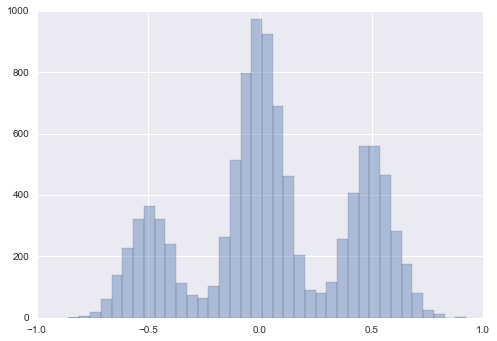

In [3]:
seaborn.distplot(samples, kde=False)

In [4]:
# Gibbs Bayesian GMM fit
K=3
# compute p(Z_i=k|X_i, mu, sigma, pi) { pi_k*N(x_i|mu_k, sigma_k)
def compute_p_z_k(samples, pi_sampled, mean_sampled, sigma_sampled):
    # Maximizes z_i
    lengths = samples.shape[0]
    K = 3
    p_z_k = np.zeros((lengths, K))
    for i in range(lengths):
        for k in range(K):
            C = 1.0 / (np.sqrt(2.0 * np.pi) * sigma_sampled[k])
            p_z_k[i][k] = pi_sampled[k]*(C * np.exp(-0.5 * ((samples[i]-mean_sampled[k])/sigma_sampled[k])**2))
        # normalize
        p_z_k[i] /= p_z_k[i].sum()
    return p_z_k

def max_zi(p_z_k, X):
    z_i = np.zeros(X)
    for i, j in enumerate(p_z_k):
        z_i[i] = np.where(j == j.max())[0]
    return z_i

def sample_z_i(p_z_k, X):
    z_i = np.zeros(X)
    components = np.array([0,1,2])
    for i, j in enumerate(p_z_k):
        z_i[i] = np.random.choice(components, 1, p=j)
    return z_i    
    
def count(z_i):
    counts = np.zeros(K)
    for i in range(K):
        counts[i] = len(np.where(z_i==i)[0])
    return counts

def sample_pi(counts, alpha):
    pi_sampled = np.random.dirichlet(alpha+counts)
    return pi_sampled

def sample_stats(samples, counts, mean_sampled, sigma_sampled, z_i):
    for i in range(K):
        if counts[i] == 0:
            print('warning, no samples in component')
        if counts[i] > 0:
            mean_sampled[i] = np.random.randn()*sigma_sampled[i]/np.sqrt(counts[i]) + np.mean(samples[np.where(z_i==i)])
        if counts[i] > 1:
            # Use improper Jeffreys prior for sigma
            chisquared = np.random.chisquare(df=(counts[i] - 1))
            sigmahat2 = np.mean((samples[np.where(z_i==i)] - mean_sampled[i])**2)
            sigma_sampled[i] = np.sqrt(sigmahat2)/np.sqrt(chisquared/counts[i])
    return mean_sampled, sigma_sampled

In [5]:
def gibbs_sampler(samples, niter):
    # randomly initialize pi, m_k, sigma_k
    K = 3
    stats = {'pi':np.zeros((niter, K)), 'mean':np.zeros((niter, K)), 'sigma':np.zeros((niter, K))}
    pi_sampled = np.random.dirichlet((1,1,1))
    mean_sampled = np.random.uniform(low=-1, high=1, size=3)
    sigma_sampled = np.random.uniform(low=0.01, high=1, size=3)
    stats['pi'][0] = pi_sampled
    stats['mean'][0] = mean_sampled
    stats['sigma'][0] = sigma_sampled
    alpha = np.ones(K)
    for i in range(1,niter):
        p_z = compute_p_z_k(samples, pi_sampled, mean_sampled, sigma_sampled)
        z_i = sample_z_i(p_z, samples.shape[0])
        counts = count(z_i)
        print counts
        stats['pi'][i] = sample_pi(counts, alpha)
        stats['mean'][i], stats['sigma'][i] = sample_stats(samples, counts, mean_sampled, sigma_sampled, z_i)
        # update alpha
        alpha = counts
    return stats
    

In [6]:
stats = gibbs_sampler(samples, 100)

[  308.  4275.  5417.]
[  968.  5273.  3759.]
[ 1232.  5168.  3600.]
[ 1330.  5071.  3599.]
[ 1364.  5042.  3594.]
[ 1410.  5001.  3589.]
[ 1415.  5017.  3568.]
[ 1446.  4999.  3555.]
[ 1461.  4960.  3579.]
[ 1498.  5000.  3502.]
[ 1506.  4984.  3510.]
[ 1536.  4958.  3506.]
[ 1598.  4894.  3508.]
[ 1664.  4759.  3577.]
[ 1754.  4617.  3629.]
[ 1805.  4514.  3681.]
[ 1842.  4445.  3713.]
[ 1856.  4420.  3724.]
[ 1881.  4364.  3755.]
[ 1875.  4299.  3826.]
[ 1902.  4279.  3819.]
[ 1912.  4188.  3900.]
[ 1919.  4113.  3968.]
[ 1917.  4030.  4053.]
[ 1924.  3989.  4087.]
[ 1921.  3956.  4123.]
[ 1931.  3876.  4193.]
[ 1928.  3802.  4270.]
[ 1925.  3792.  4283.]
[ 1934.  3761.  4305.]
[ 1921.  3675.  4404.]
[ 1928.  3649.  4423.]
[ 1912.  3619.  4469.]
[ 1921.  3544.  4535.]
[ 1925.  3493.  4582.]
[ 1930.  3445.  4625.]
[ 1926.  3411.  4663.]
[ 1917.  3339.  4744.]
[ 1907.  3277.  4816.]
[ 1926.  3213.  4861.]
[ 1922.  3166.  4912.]
[ 1923.  3131.  4946.]
[ 1911.  3116.  4973.]
[ 1914.  30

In [7]:
print('True Pi: %s' % coef)
print('estimated: %s' % stats['pi'][-1])
stats['pi'][-2]

True Pi: [ 0.2  0.5  0.3]
estimated: [ 0.19429396  0.30341351  0.50229253]


array([ 0.18749199,  0.30481434,  0.50769367])

In [8]:
print ('True means: %s' % means)
print('estimated means: %s' % stats['mean'][-1])


True means: [-0.5  0.   0.5]
estimated means: [ -4.91629578e-01   4.96607764e-01  -2.55237489e-04]


In [9]:
print('True sigmas: %s' % sigmas)
print('estimated sigmas: %s' % stats['sigma'][-1])

True sigmas: [ 0.1  0.1  0.1]
estimated sigmas: [ 0.10365074  0.11007067  0.09446018]


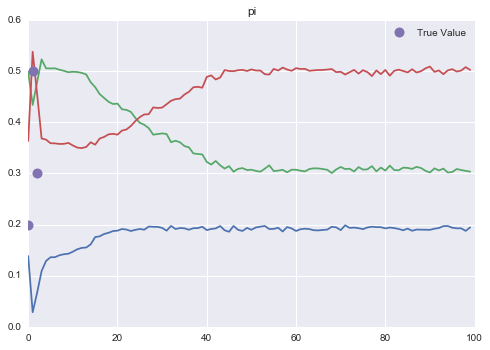

In [10]:
plt.plot(stats['pi'][:,0])
plt.plot(stats['pi'][:,1])
plt.plot(stats['pi'][:,2])
plt.title('pi')
plt.plot(coef, '.', markersize=20, label='True Value')
plt.legend()

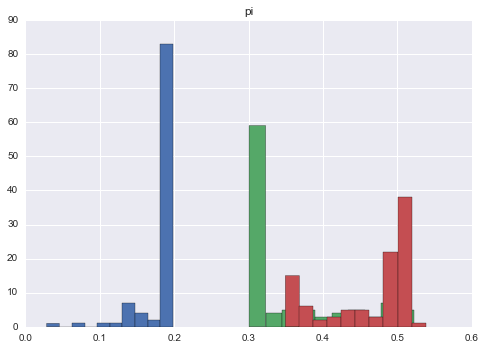

In [11]:
plt.hist(stats['pi'][:,0])
plt.hist(stats['pi'][:,1])
plt.hist(stats['pi'][:,2])
plt.title('pi')
#plt.plot(coef, '.', markersize=20, label='True Value')
#plt.legend()

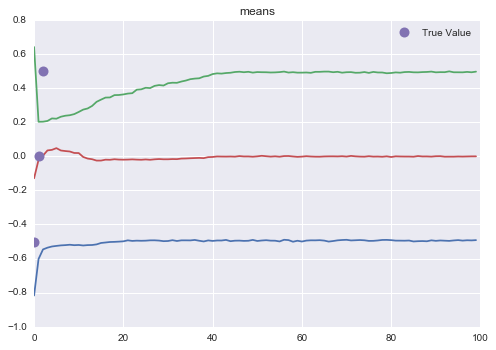

In [12]:
plt.plot(stats['mean'][:,0])
plt.plot(stats['mean'][:,1])
plt.plot(stats['mean'][:,2])
plt.title('means')
plt.plot(means, '.', markersize=20, label='True Value')
plt.legend()

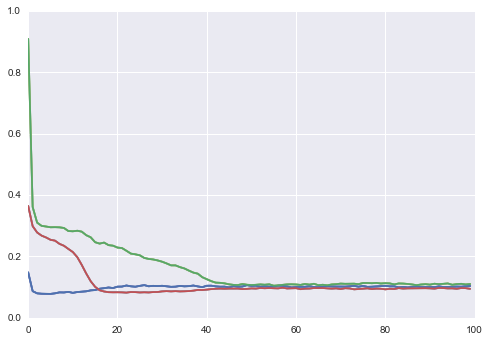

In [13]:
plt.plot(stats['sigma'])
plt.plot(stats['sigma'])
plt.plot(stats['sigma'])

In [18]:
pi_sampled = np.random.dirichlet((1,1,1))
mean_sampled = np.random.uniform(low=-1, high=1, size=3)
sigma_sampled = np.random.uniform(low=0.01, high=1, size=3)

In [32]:
p_z = compute_p_z_k(samples, pi_sampled, mean_sampled, sigma_sampled)

In [33]:
z_i = sample_z_i(p_z, samples.shape[0])

(array([ 48945.,      0.,      0.,      0.,      0.,  42659.,      0.,
             0.,      0.,   8396.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

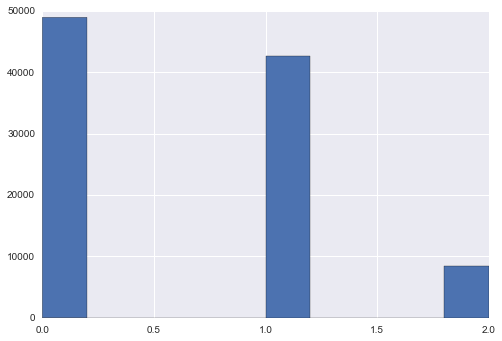

In [35]:
plt.hist(z_i)

In [36]:
z_i_max = max_zi(p_z, samples.shape[0])

(array([ 59190.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  40810.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

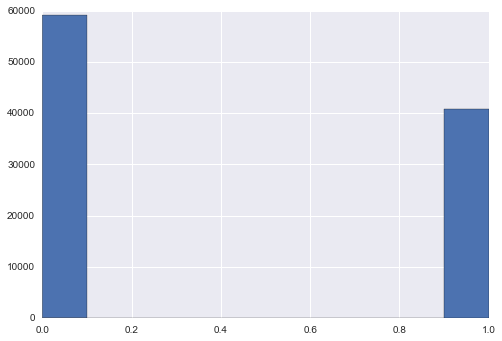

In [37]:
plt.hist(z_i_max)

In [39]:
pi_sampled

array([ 0.65046623,  0.31070811,  0.03882566])